# How Fast Can You CitiBike?

## ML Question 4: Modeling Trip Durations

<a id=toc></a>
## Table of Contents

<ul>
    <li><a href=#01-import-packages>Import Packages</a>
    <li><a href=#02-load-dataset>Load Dataset and Check Properties</a>
    <li><a href=#03-feat-eng>Perform Feature Engineering</a>
    <li><a href=#04-split-data>Split Train and Test Data</a>
    <li><a href=#05-regression>Perform Regression</a>
    <li><a href=#06-validate>Validate Model</a>
    <li><a href=#07-beta-coeff>Calculate Beta Coefficients</a>
    <li><a href=#08-save-pickle>Save Model as Pickle File</a>
</ul>

<a id=01-import-packages></a>
## Import Packages

Import all necessary packages.

In [1]:
# Apache parquet files (to save space)
import pyarrow as pa
import pyarrow.parquet as pq

# Dataframes and numerical
import pandas as pd
import numpy as np
import statistics

# Increase pandas default display 
pd.options.display.max_rows = 250
pd.options.display.max_columns = 250

# Suppress scientific notation of data in pandas
pd.set_option('display.float_format', '{:.2f}'.format)

# Graphing
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.gridspec as gridspec
import seaborn as sns
sns.set_style('darkgrid')
plt.style.use('fivethirtyeight')

# For data preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats

# Library for model creation
from sklearn.linear_model import LinearRegression,SGDRegressor
from sklearn.linear_model import Lasso
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split,GridSearchCV

# Model evaluation
from sklearn.metrics import mean_squared_error,r2_score

# Silence warnings
import warnings
warnings.filterwarnings('ignore')

<a href=#toc>Back to the top</a>

<a id=02-load-dataset></a>
## Load Dataset and Check Properties

Load **.parquet** file of all CitiBike rides from May 2021 through April 2022 into **pandas** dataframe.

In [2]:
CB_Data = pq.read_table('data/202105-202204-citibike-tripdata.parquet').to_pandas()

Preview the dataset.

In [3]:
CB_Data.head()

,member_casual,rideable_type,started_at,start_station_name,start_lat,start_lng,start_boro,start_hood,ended_at,end_station_name,end_lat,end_lng,end_boro,end_hood,year,month,week_of_year,day_of_week,hour_of_day,duration_min,distance_mi,speed_mph
1,Member,Classic Bike,2021-05-13 12:48:08,Broadway & W 25 St,40.74,-73.99,Manhattan,Flatiron District,2021-05-13 13:07:37,E 2 St & Avenue B,40.72,-73.98,Manhattan,East Village,2021,5,19,3,12,19.48,1.81,5.57
2,Member,Classic Bike,2021-05-16 08:30:13,46 Ave & 5 St,40.75,-73.95,Queens,Long Island City,2021-05-16 08:45:47,34th Ave & Vernon Blvd,40.77,-73.94,Queens,Long Island City,2021,5,19,6,8,15.57,2.26,8.69
3,Member,Classic Bike,2021-05-01 08:38:14,46 Ave & 5 St,40.75,-73.95,Queens,Long Island City,2021-05-01 08:54:27,34th Ave & Vernon Blvd,40.77,-73.94,Queens,Long Island City,2021,5,17,5,8,16.22,2.26,8.35
4,Member,Classic Bike,2021-05-09 08:12:31,46 Ave & 5 St,40.75,-73.95,Queens,Long Island City,2021-05-09 08:27:05,34th Ave & Vernon Blvd,40.77,-73.94,Queens,Long Island City,2021,5,18,6,8,14.57,2.26,9.29
5,Member,Classic Bike,2021-05-27 07:52:27,E 123 St & Lexington Ave,40.80,-73.94,Manhattan,East Harlem,2021-05-27 08:09:01,1 Ave & E 78 St,40.77,-73.95,Manhattan,Upper East Side,2021,5,21,3,7,16.57,3.25,11.78


In [4]:
CB_Data.tail()

,member_casual,rideable_type,started_at,start_station_name,start_lat,start_lng,start_boro,start_hood,ended_at,end_station_name,end_lat,end_lng,end_boro,end_hood,year,month,week_of_year,day_of_week,hour_of_day,duration_min,distance_mi,speed_mph
28816542,Member,Electric Bike,2022-04-29 09:03:34,Broadway & Berry St,40.71,-73.97,Brooklyn,Williamsburg,2022-04-29 09:16:23,Water St & Main St,40.70,-73.99,Brooklyn,DUMBO,2022,4,17,4,9,12.82,2.24,10.46
28816543,Member,Classic Bike,2022-04-22 13:08:15,Allen St & Rivington St,40.72,-73.99,Manhattan,Lower East Side,2022-04-22 13:29:31,W 29 St & 9 Ave,40.75,-74.00,Manhattan,Chelsea,2022,4,16,4,13,21.27,2.64,7.45
28816544,Member,Classic Bike,2022-04-13 17:10:49,St. Nicholas Terrace & Convent Ave,40.82,-73.95,Manhattan,Harlem,2022-04-13 17:26:08,E 138 St & Grand Concourse,40.81,-73.93,Bronx,Mott Haven,2022,4,15,2,17,15.32,1.75,6.85
28816546,Member,Electric Bike,2022-04-28 15:52:49,W 55 St & 6 Ave,40.76,-73.98,Manhattan,Midtown,2022-04-28 16:06:31,E 91 St & 2 Ave,40.78,-73.95,Manhattan,Upper East Side,2022,4,17,3,15,13.70,3.23,14.13
28816547,Member,Electric Bike,2022-04-11 19:55:31,W 87 St & West End Ave,40.79,-73.98,Manhattan,Upper West Side,2022-04-11 20:09:19,E 91 St & 2 Ave,40.78,-73.95,Manhattan,Upper East Side,2022,4,15,0,19,13.80,2.51,10.92


Describe the dataset.

In [5]:
CB_Data.describe(include='all').T

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
member_casual,18658426,2,Member,13885173,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rideable_type,18658426,2,Classic Bike,13019655,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
started_at,18658426,12040084,2021-06-25 19:08:09,27,2021-05-01 00:00:01,2022-04-30 23:59:59,NaN,NaN,NaN,NaN,NaN,NaN,NaN
start_station_name,18658426,1587,W 21 St & 6 Ave,84118,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
start_lat,18658426.00,NaN,NaN,NaN,NaT,NaT,40.74,0.04,40.63,40.72,40.74,40.76,40.88
start_lng,18658426.00,NaN,NaN,NaN,NaT,NaT,-73.98,0.02,-74.04,-73.99,-73.98,-73.96,-73.88
start_boro,18658426,5,Manhattan,13542212,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
start_hood,18658426,89,Chelsea,1429536,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ended_at,18658426,12033810,2021-05-05 23:31:09,36,2021-05-01 00:06:03,2022-05-01 00:48:28,NaN,NaN,NaN,NaN,NaN,NaN,NaN
end_station_name,18658426,1654,W 21 St & 6 Ave,88605,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<a href=#toc>Back to the top</a>

<a id=03-feat-eng></a>
## Perform Feature Engineering

**Develop Model for Ride Durations Between Stations**

The dependent variable shall be the duration of the ride between two stations.

The independent variables shall be the following:

1. Month of Year
2. Week of Year
3. Hour of Day
4. Start Neighborhood
5. Start Borough
6. End Neighborhood
7. End Borough
8. Bike Type
9. Member Type
10. Distance between Stations

In [6]:
CB_Duration = pd.DataFrame(
    CB_Data.groupby(
        ['start_station_name','end_station_name','month','week_of_year','day_of_week','hour_of_day',
         'start_hood','start_boro','end_hood','end_boro','rideable_type','member_casual','distance_mi']
    )['duration_min'].mean()
).reset_index('start_station_name').reset_index('end_station_name').reset_index()

In [7]:
CB_Duration.shape

(17742205, 14)

In [8]:
CB_Duration.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17742205 entries, 0 to 17742204
Data columns (total 14 columns):
 #   Column              Dtype  
---  ------              -----  
 0   month               int64  
 1   week_of_year        int64  
 2   day_of_week         int64  
 3   hour_of_day         int64  
 4   start_hood          object 
 5   start_boro          object 
 6   end_hood            object 
 7   end_boro            object 
 8   rideable_type       object 
 9   member_casual       object 
 10  distance_mi         float64
 11  end_station_name    object 
 12  start_station_name  object 
 13  duration_min        float64
dtypes: float64(2), int64(4), object(8)
memory usage: 1.9+ GB


In [9]:
CB_Duration_col_order = ['start_station_name','end_station_name','duration_min','distance_mi',
                        'member_casual','rideable_type','month','week_of_year','day_of_week',
                        'hour_of_day','start_hood','start_boro','end_hood','end_boro']
CB_Duration = CB_Duration[CB_Duration_col_order]

Binarize **member_casual** and **rideable_type**.

In [10]:
# Assign 0 for Casual and 1 for Member
CB_Duration.member_casual = CB_Duration.member_casual.apply(lambda x: 1 if (x == 'Member') else 0).astype(int)

# Assign 0 for Classic Bike and 1 for Electric Bike
CB_Duration.rideable_type = CB_Duration.rideable_type.apply(lambda x: 1 if (x == 'Electric Bike') else 0).astype(int)

Binarize **day_of_week** according to whether it is a day of the week (Monday - Friday) or weekend (Saturday/Sunday).

In [11]:
# Assign 0 for weekday (Monday - Friday) and 1 for weekend (Saturday/Sunday)
CB_Duration.day_of_week = CB_Duration.day_of_week.apply(lambda x: 1 if (x >= 5) else 0).astype(int)

Create a categorical variable indicating whether or not the origin and destinations are of the same neighborhood and/or borough.

In [12]:
# Assign 0 if the same and 1 if different
CB_Duration['diff_hood'] = np.where(CB_Duration.start_hood == CB_Duration.end_hood, 0, 1).astype(int)
CB_Duration['diff_boro'] = np.where(CB_Duration.start_boro == CB_Duration.end_boro, 0, 1).astype(int)

In [13]:
CB_Duration.head()

,start_station_name,end_station_name,duration_min,distance_mi,member_casual,rideable_type,month,week_of_year,day_of_week,hour_of_day,start_hood,start_boro,end_hood,end_boro,diff_hood,diff_boro
0,1 Ave & E 110 St,1 Ave & E 16 St,37.52,7.14,1,1,6,22,1,18,East Harlem,Manhattan,Stuyvesant Town,Manhattan,1,0
1,1 Ave & E 110 St,1 Ave & E 16 St,29.88,7.14,1,1,7,29,1,22,East Harlem,Manhattan,Stuyvesant Town,Manhattan,1,0
2,1 Ave & E 110 St,1 Ave & E 16 St,57.35,7.14,0,1,8,33,0,22,East Harlem,Manhattan,Stuyvesant Town,Manhattan,1,0
3,1 Ave & E 110 St,1 Ave & E 16 St,30.10,7.14,1,1,12,50,1,13,East Harlem,Manhattan,Stuyvesant Town,Manhattan,1,0
4,1 Ave & E 110 St,1 Ave & E 30 St,62.90,6.07,0,1,3,9,1,13,East Harlem,Manhattan,Kips Bay,Manhattan,1,0


In [14]:
CB_Duration.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17742205 entries, 0 to 17742204
Data columns (total 16 columns):
 #   Column              Dtype  
---  ------              -----  
 0   start_station_name  object 
 1   end_station_name    object 
 2   duration_min        float64
 3   distance_mi         float64
 4   member_casual       int64  
 5   rideable_type       int64  
 6   month               int64  
 7   week_of_year        int64  
 8   day_of_week         int64  
 9   hour_of_day         int64  
 10  start_hood          object 
 11  start_boro          object 
 12  end_hood            object 
 13  end_boro            object 
 14  diff_hood           int64  
 15  diff_boro           int64  
dtypes: float64(2), int64(8), object(6)
memory usage: 2.1+ GB


<a href=#toc>Back to the top</a>

<a id=04-split-data></a>
## Split Train and Test Data

In [15]:
# Determine independent variables
ind_var = ['distance_mi','member_casual','rideable_type',
            'month','week_of_year','day_of_week','hour_of_day',
            'diff_hood','diff_boro']
x = CB_Duration[ind_var]

# Determine dependent variables
dep_var = ['duration_min']
y = CB_Duration[dep_var]

# Importing train_test_split from sklearn
from sklearn.model_selection import train_test_split

# Splitting the data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 100)

<a href=#toc>Back to the top</a>

<a id=05-regression></a>
## Perform Regression

Import packages for performing the **Penalized Regression** methods.

In [16]:
from sklearn.linear_model import Ridge, Lasso
from sklearn import datasets

Perform **Ridge Regression**.

In [17]:
ridge = Ridge()
ridge.fit(x_train, y_train)
print('the ridge intercept is: %.2f' %(ridge.intercept_))
ridge.score(x_test, y_test)

the ridge intercept is: 2.32


0.7690848566951879

Perform **Lasso Regression**.

In [18]:
lasso  = Lasso()
alphas = np.linspace(0.001,1.1,20)
lasso.set_params(normalize=False)
coefs_lasso  = []
score_lasso  = []

for alpha in alphas:
        lasso.set_params(alpha=alpha)
        lasso.fit(x_train, y_train)  
        coefs_lasso.append(lasso.coef_)
        score_lasso.append(lasso.score(x_test, y_test))

coefs_lasso = pd.DataFrame(coefs_lasso, index = alphas, columns = x.columns)  
score_lasso

[0.7690846224439649,
 0.7675409106597191,
 0.7632474059883467,
 0.7603206652273345,
 0.7571145411822917,
 0.7543465985895127,
 0.7518453654572312,
 0.748890332833591,
 0.7479231791258342,
 0.747578289868168,
 0.7471930437900325,
 0.7467674408953807,
 0.7463014811842128,
 0.7457951646565286,
 0.7452484913123285,
 0.744661461151612,
 0.7440340741743792,
 0.7433663303806303,
 0.742658229770365,
 0.7419097723435839]

**Ridge Regression** is good enough for its level of performance, and shall now be cross-validated.

<a href=#toc>Back to the top</a>

<a id=06-validate></a>
## Validate Model

Check the accuracy of the train vs test data.

In [22]:
ridge.fit(x_train, y_train)
print("Train Score", ridge.score(x_train, y_train))
ridge.fit(x_test, y_test)
print("Test Score", ridge.score(x_test, y_test))

Train Score 0.7690889811631176
Test Score 0.7690850637944872


<a href=#toc>Back to the top</a>

<a id=07-beta-coeff></a>
## Calculate Beta Coefficients

See which features have the most impact.

In [29]:
x.columns.tolist()

['distance_mi',
 'member_casual',
 'rideable_type',
 'month',
 'week_of_year',
 'day_of_week',
 'hour_of_day',
 'diff_hood',
 'diff_boro']

In [63]:
print(list(np.concatenate(rid_reg.coef_.tolist()).flat))

[5.313892470908161, -1.382503439099558, -2.27001423167824, 0.04101408913322289, -0.0016921399328646153, 0.5569447245653932, 0.06474265162730652, 0.8931509614166836, 1.8558011227892057]


In [60]:
print(rid_reg.feature_names_in_.tolist())

['distance_mi', 'member_casual', 'rideable_type', 'month', 'week_of_year', 'day_of_week', 'hour_of_day', 'diff_hood', 'diff_boro']




 Dummy train score  0.0
 Dummy test score  -1.6994274210091476e-08


train score  0.7690889811631176
test score  0.7690848566951879


Text(0.5, 0, 'Feature names')

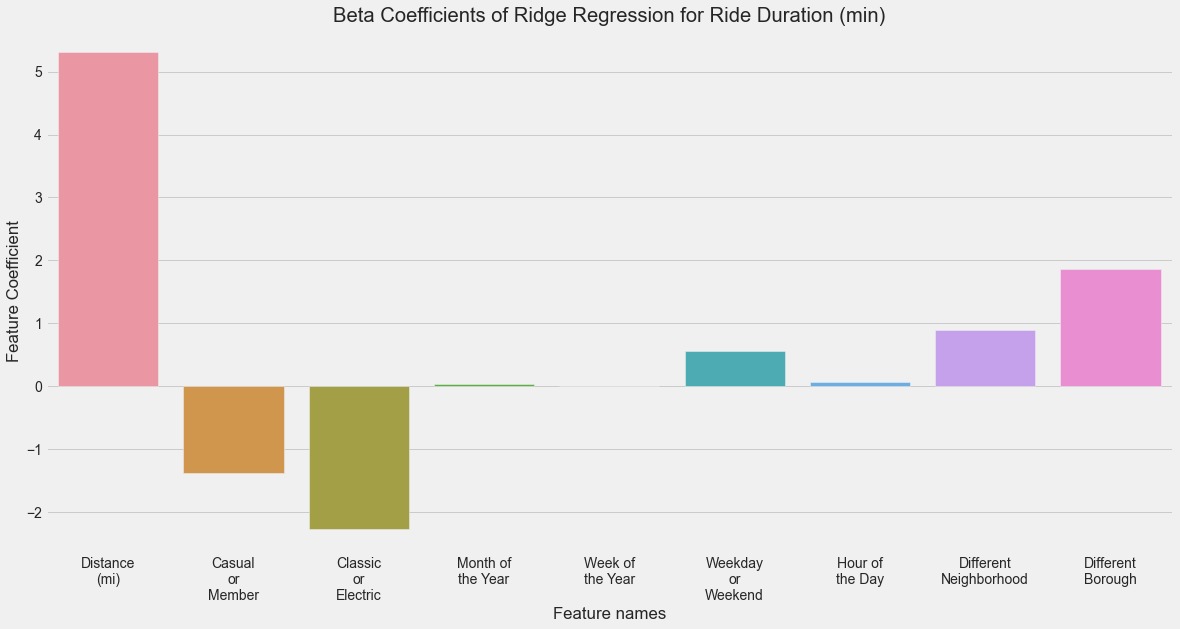

In [69]:
# Fit to data
rid_reg = ridge.fit(x_train,y_train)

# Generate prediction
prediction = rid_reg.predict(x_test)

# Use the DummyRegressor as baseline in comparism to the real regressor
lm_dummy_mean = DummyRegressor(strategy = 'mean').fit(x_train, y_train)
y_predict_dummy_mean = lm_dummy_mean.predict(x_test)

print('\n\n Dummy train score ',lm_dummy_mean.score(x_train,y_train))
print(' Dummy test score ',lm_dummy_mean.score(x_test,y_test))

print('\n\ntrain score ',rid_reg.score(x_train,y_train))
print('test score ',rid_reg.score(x_test,y_test))

params = rid_reg.feature_names_in_.tolist()
coeffs = list(np.concatenate(rid_reg.coef_.tolist()).flat)

fig,ax = plt.subplots(figsize=(18,9))
sns.barplot(params,coeffs)
# plt.xticks(rotation=90)
ax.set_xticklabels(['Distance\n(mi)','Casual\nor\nMember','Classic\nor\nElectric','Month of\nthe Year',
                    'Week of\nthe Year','Weekday\nor\nWeekend','Hour of\nthe Day','Different\nNeighborhood',
                    'Different\nBorough'])
plt.title('Beta Coefficients of Ridge Regression for Ride Duration (min)')
plt.ylabel('Feature Coefficient')
plt.xlabel('Feature names')

<a href=#toc>Back to the top</a>

<a id=08-save-pickle></a>
## Calculate Beta Coefficients

Save model as **pickle** file for future use.

In [71]:
import pickle

# Save the model
with open('model/CB_Duration_Ridge.pkl','wb') as f:
     pickle.dump(rid_reg, f)

<a href=#toc>Back to the top</a>